In [1]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats

# Download Yahoo Data (5 minute interval)

In [24]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '10m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed

21 Failed downloads:
- AAPL: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- UPS: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- FB: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- UNH: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- V: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- AMZN: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- CRM: Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
- MMM: Inval

SyntaxError: syntax error at or near ";"
LINE 1: INSERT INTO stockprice (datetime, symbol, price) VALUES ;
                                                                ^


In [22]:
stocks.raw_data.shape

(387, 126)

In [4]:
stocks.transformed_data.to_csv('data/mydata.csv')

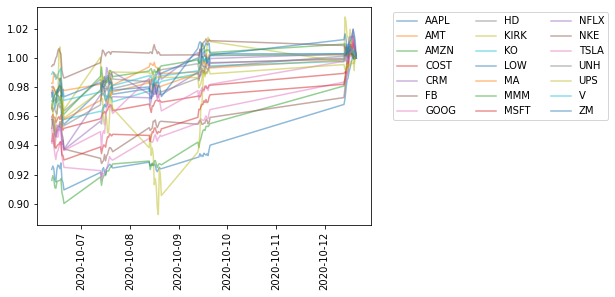

In [5]:
stocks.plot_raw(scale = -1)

# Model

In [6]:
stocks.transformed_data

,symbol,price
DateTime,,
2020-10-12 15:30:00,AAPL,124.419998
2020-10-08 11:30:00,AAPL,115.230003
2020-10-08 11:00:00,AAPL,115.445000
2020-10-08 10:30:00,AAPL,115.264999
2020-10-08 10:00:00,AAPL,115.209999
...,...,...
2020-10-08 15:30:00,ZM,478.480011
2020-10-08 15:00:00,ZM,480.378906
2020-10-08 14:30:00,ZM,482.429993


In [7]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Note if pulling from SQL index = 'DateTime'
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [8]:
def get_MASE(data,lags):
    # Calculate Q for each series. MAE of naive forecast for each series
    Q = np.abs(data.diff().dropna()).mean()
    # Calculate MASE for each series as 
    MASE = []
    MASEN = []
    n_ahead = 1
    # rolling origin point forecasts.
    # has to train on at least n = lags samples
    for n in range(lags,(data.shape[0] - 1)):
        try:
            M = YahooStocks.Model(data=data.iloc[0:n])
            M.fitVAR(lags)
            M.forecast(n_ahead)
            MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
            MAE = np.abs((data.iloc[n].values - M.fcast.values))[0]
            MASE.append(MAE/Q)
            MASEN.append(MAEnaive/Q)
        except:
            continue
    return MASE, MASEN

In [9]:
data.shape

(65, 21)

In [10]:
lags = 50
MASE, MASEN = get_MASE(data, 50)

# Significance Testing

In [11]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

1.003737691223743
1.111358467675825


Ttest_relResult(statistic=-1.2621059000402692, pvalue=0.2081889893528916)

In [12]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
stats.ttest_ind(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL'])

Ttest_indResult(statistic=-0.9611328177122281, pvalue=0.34796236996240903)

In [13]:
# pairwise ttest between naive and var. Nobody looks significant, e.g. aapl naive to aapl var for all stocks
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

array([0.34796237, 0.39380721, 0.45988321, 0.783063  , 0.73487301,
       0.79699063, 0.45718733, 0.84608324, 0.83493562, 0.92034112,
       0.6152528 , 0.81331565, 0.98552561, 0.61520816, 0.60318693,
       0.84558924, 0.42484153, 0.55967651, 0.91576239, 0.43426155,
       0.69450784])

In [14]:
A = pd.DataFrame(MASE).mean().values
B = pd.DataFrame(MASEN).mean().values

In [15]:
stats.ttest_ind(A, B)

Ttest_indResult(statistic=-0.9328532108634501, pvalue=0.35649276806717445)

In [16]:
F, p = stats.f_oneway(A, B, axis = 0)
p

0.3564927680671742

In [17]:
# Are there any stocks that are more predictable than others? Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.3441051130986221, pvalue=0.9964879191390494)

-0.10762077645208194


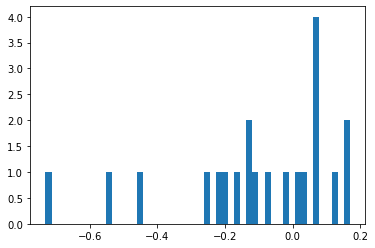

In [18]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

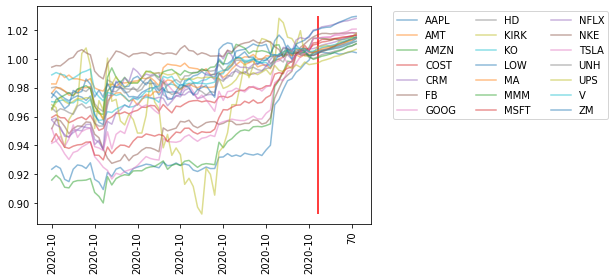

In [19]:
M = YahooStocks.Model(data=data.iloc[0:-3])
M.fitVAR(lags)
M.forecast(10)
M.plot_fcast()

In [20]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
NFLX    1.020513
ZM      1.020254
FB      1.016566
TSLA    1.014336
AMZN    1.014247
GOOG    1.013946
MSFT    1.011363
COST    1.010299
KIRK    1.008250
CRM     1.008175
V       1.006357
MA      1.005468
AMT     1.005440
AAPL    1.004779
UNH     1.004701
KO      1.004433
LOW     1.003598
NKE     1.003591
HD      1.001285
MMM     1.000628
UPS     0.996990
Name: 62, dtype: float64